In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [0]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

In [0]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  train = data[:-n_test]
  test = data[-n_test:]
  X_train, y_train = train[:, 0:-1], train[:, -1]
  X_test, y_test = test[:, 0:-1], test[:, -1]
  return  X_train, X_test, y_train, y_test

In [0]:
# scale train and test data to [0, 1]
def scale(data):
  scaler = MinMaxScaler()
  scaler.fit(data)
  data_scale = scaler.transform(data)
  return scaler, data_scale

In [0]:
def invert_scale(scaler, data):
  data = data.reshape(data.shape[0],1)
  return  scaler.inverse_transform(data)

In [0]:
# fit an MLP network to training data
def fit_model(X_train ,y_train, batch_size, nb_epoch, hidden_layers, neurons):
  model = Sequential()
  model.add(Dense(neurons, activation='relu', input_dim=X_train.shape[1]))
  for i in range(hidden_layers):
    # Add one hidden layer
    model.add(Dense(neurons, kernel_initializer= 'normal', activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
  return model

In [0]:
def walk_forward_validation(X, y, model, scaler):
    y_pred = model.predict(X)
    y_pred_inverse = invert_scale(scaler, y_pred)
    y_inverse = invert_scale(scaler, y)  
    rmse = sqrt(mean_squared_error(y_inverse, y_pred_inverse))
    return rmse


In [0]:
def iterative_validation(X, y, model, scaler):
    series = X.reshape(1, X.shape[0])
    prediction = []
    for i in range(200):
      y_pred = model.predict(series.reshape(1, series.shape[1]))
      prediction.append(invert_scale(scaler, y_pred))
      series=np.delete(series, 0)
      series= np.append(series, y_pred)
      series = series.reshape(1, series.shape[0])
    prediction = np.array(prediction).reshape(200,1)
    y_inverse = invert_scale(scaler, y)
    rmse = sqrt(mean_squared_error(y_inverse, prediction))
    time = np.arange(200)
    plt.plot(time, y_inverse, label='real value')
    plt.plot(time, prediction, label='prediction')
    plt.title("Comparison over 200 predictions test")
    plt.xlabel('time')
    plt.ylabel('values')
    plt.legend()
    plt.show()
    return rmse

In [0]:
# run a repeated experiment
def experiment(config):
  repeats, series, epochs, batch_size, hidden_layers, neurons, lag = config
  #scale data
  scaler, series_scaled = scale(series)
  supervised_values = series_to_supervised(series_scaled, lag)
  # split data into train and test-sets
  X_train, X_test, y_train, y_test  = train_test_split(supervised_values, 200)
  # run experiment
  error_scores = list()
  
  for r in range(repeats):
    try:
      print(r)
      # fit the model
      model = fit_model(X_train,y_train, batch_size, epochs, hidden_layers, neurons)
      #walk_forward_validation
      #rmse =walk_forward_validation(X_test, y_test, model ,scaler)
      #iterative_validation
      rmse = iterative_validation(X_test[0], y_test,model, scaler)
      #print('%d) Test RMSE: %.3f' % (r+1, rmse))
      if(rmse > 100):
        error_scores.append(100)
      else:
        error_scores.append(rmse)  
    except:
      error_scores.append(100)
  
  return error_scores

In [0]:
def configuration(dictionary, num):
  print(dictionary[str(num)])

---------------------------------------------------------------------------
model =  1
0


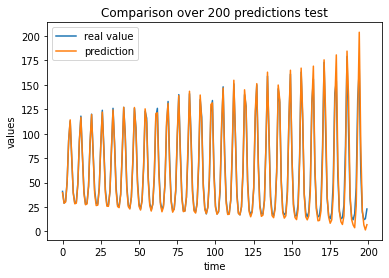

              1
count  1.000000
mean   6.646473
std         NaN
min    6.646473
25%    6.646473
50%    6.646473
75%    6.646473
max    6.646473


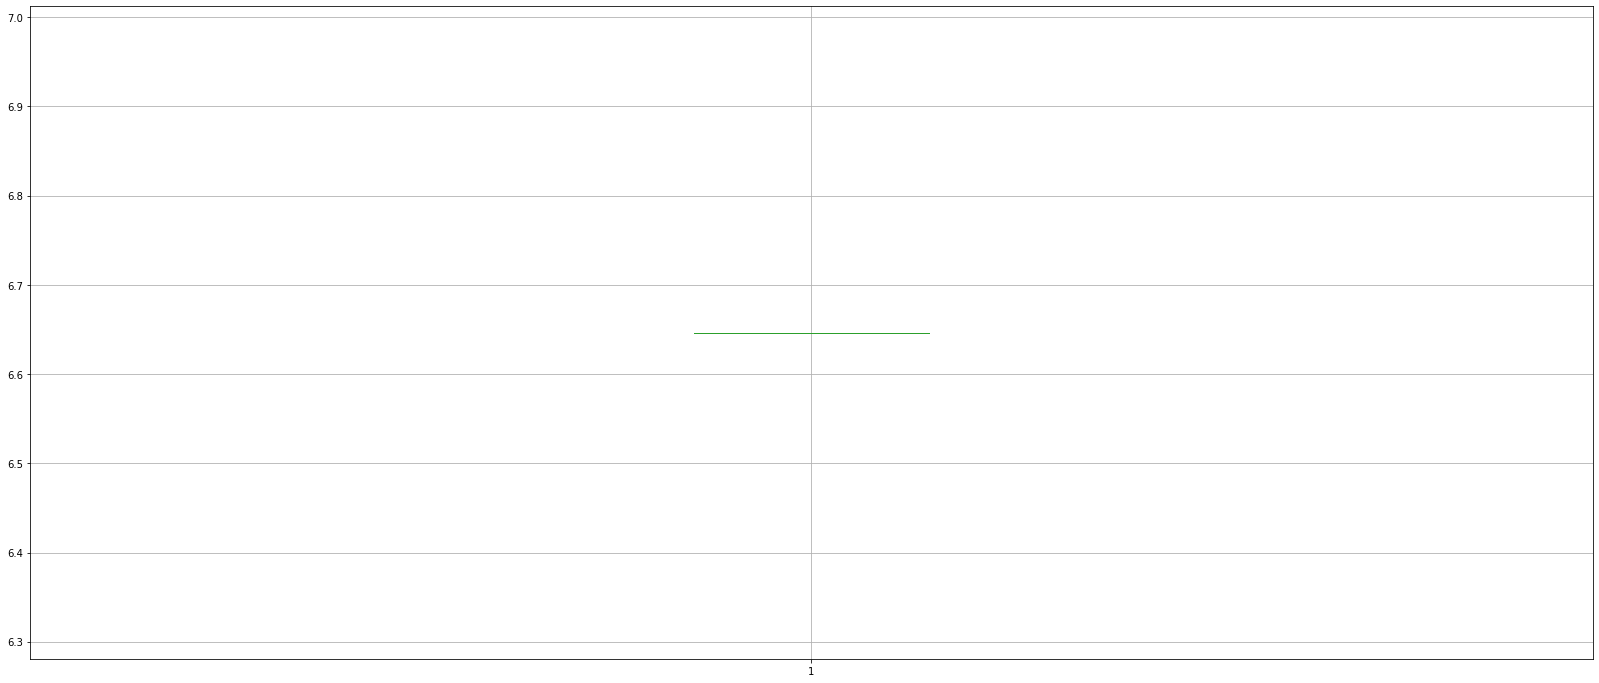

In [12]:
# load dataset
series = loadmat('Xtrain.mat')
series = series['Xtrain']

# experiment
repeats = 1
results = DataFrame()
n_epochs = [10000]
n_batch = [1000]
n_hidden_layers = [0,1,2]#One hidden layer is already present by default, so it indicates the number of hidden layers after the first hidden layer
n_neurons = [8,16,32,64,128]
#n_lags = [12, 20, 30, 50, 100]
n_lags = [90]
count = 0
dictionary = {}
for epochs in n_epochs:
  for batch in n_batch:
   for hidden_layers in n_hidden_layers:
      for neurons in n_neurons:
        for lag in n_lags:
          print("---------------------------------------------------------------------------")
          count  = count + 1
          print("model = ", count)
          dictionary[str(count)] = "Model -> Number Epoch = " + str(epochs) + ", Batch size = " + str(batch) + ", Number Hidden layer = " + str(hidden_layers) + ", Number of neurons = " + str(neurons) + ", Number of lag = " + str(lag)
          cfg = [repeats, series, epochs, batch, hidden_layers, neurons, lag]
          results[str(count)] = experiment(cfg)
# summarize results
print(results.describe())
# save boxplot
results.boxplot(figsize=(28, 12))
# pyplot.savefig('boxplot_neurons.png')




In [15]:
results

,1
0,6.646473


In [0]:
configuration(dictionary,10)

Model -> Number Epoch = 10000, Batch size = 1000, Number Hidden layer = 1, Number of neurons = 128, Number of lag = 20


In [0]:
series = loadmat('Xtrain.mat')
series = series['Xtrain']
lag = 90

scaler, series_scaled = scale(series)
supervised_values = series_to_supervised(series_scaled, lag )
# split data into train and test-sets
X_train, X_test, y_train, y_test  = train_test_split(supervised_values, 200)
model = fit_model(X_train , y_train, batch_size = 1000, nb_epoch = 10000, hidden_layers = 1, neurons = 128)

In [0]:
series = loadmat('Xtrain.mat')
series = series['Xtrain']
lag = 90
scaler, series_scaled = scale(series)
series_scaled = series_scaled[-lag:].reshape(1,lag)
prediction = []
for i in range(200):
  y_pred = model.predict(series_scaled.reshape(1,lag))
  prediction.append(scaler.inverse_transform(y_pred))
  series_scaled = np.delete(series_scaled, 0)
  series_scaled= np.append(series_scaled, y_pred)
prediction = np.array(prediction).reshape(200,1)

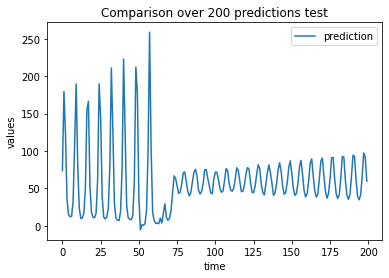

In [60]:
time = np.arange(200)
plt.plot(time, prediction, label='prediction')
plt.title("Comparison over 200 predictions test")
plt.xlabel('time')
plt.ylabel('values')
plt.legend()
plt.show()

Observations: 1000
Training Observations: 800
Testing Observations: 200


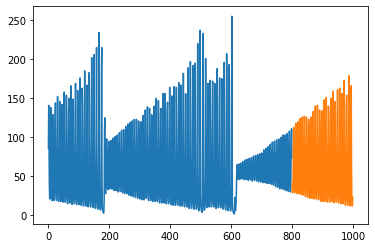

In [65]:
from pandas import read_csv
from matplotlib import pyplot
series = loadmat('Xtrain.mat')
series = series['Xtrain']
X = series
train, test = X[0:800], X[800:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
pyplot.plot(train)
pyplot.plot([None for i in train] + [x for x in test])
pyplot.show()